# Disconnectome analysis (CN vs. MCI)

In this notebook we are going to analyze differences between CN and MCI patients regarding damage to the WM tracts and regarding differences in the (dis)connectome.

In [1]:
# Imports and directories
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as ss
import matplotlib.pyplot as plt
from statannot import add_stat_annotation
from pathlib import Path
from scipy.stats import ttest_ind

SPINE = Path.cwd().parents[2]
DATA_DIR = SPINE / "data"
UTL_DIR = DATA_DIR / "utils"
RES_DIR = SPINE / "results"
LQT_DIR = RES_DIR / "LQT"
DF_DIR = LQT_DIR / "dataframes"

#Read in dataframes
pts_df = pd.read_csv(RES_DIR / "ADNIMERGE_petTOAD.csv", index_col = [0])
tract_discon = pd.read_csv(DF_DIR / "tract_discon.csv", index_col= [0])
parc_discon = pd.read_csv(DF_DIR / "parc_discon.csv", index_col= [0])
parc2parc_discon = pd.read_csv(DF_DIR / "parc2parc_discon.csv", index_col= [0])
net_discon = pd.read_csv(DF_DIR / "net_discon.csv", index_col= [0])
net2net_discon = pd.read_csv(DF_DIR / "net2net_discon.csv", index_col= [0])

# Create function to clean up the initial df and apply it 
def tidy_df(df):
    df = df.rename(columns={'ID': 'PTID'})
    df['PTID'] = df['PTID'].str.replace("sub-","")
    return df

tract_discon = tidy_df(tract_discon)
parc_discon = tidy_df(parc_discon)
parc2parc_discon = tidy_df(parc2parc_discon)
net_discon = tidy_df(net_discon)
net2net_discon = tidy_df(net2net_discon)

# Current implementation to say that a patient has WMH is based on the threshold of the subj space WMH volume
pts_df['WMH'] = np.where(pts_df["Group_bin_subj"].str.contains("no_WMH"), "no_WMH", "WMH")

# Create helper df
help_df = pts_df[['PTID', 'Group_bin']]

## Groupwise differences in mean tract/parcellation/network damage
First, let's see if there are any differences in terms of damage to the white matter tracts or in terms of damage to specific networks or parcellation combinations (t-test compare between groups with Bonferroni correction)...

There seems to be no statistically significant differences regarding damage to the white matter tracts in CN and MCI.

In [2]:
def analyze_df(init_df):
    df = pd.merge(help_df, init_df, on = "PTID")

    # Create long version of the dataframe for plotting with seaborn
    val_vars= [f for f in df.columns if f not in ['PTID']]
    df_long = pd.melt(df, id_vars = ['PTID', 'Group_bin'], value_vars = val_vars, value_name="Damage")

    # mci_df_long = df_long[df_long['Group_bin'] == 'MCI']
    # mean_order = mci_df_long.groupby('variable')['Damage'].mean(numeric_only = True).sort_values(ascending = False)
    # sns_order = mean_order.index
    # sns.set(rc={'figure.figsize':(25,5)})
    # sns.set_theme(style = 'whitegrid')
    # sns.barplot(data = df_long, x = 'variable', y = "Damage", hue = 'Group_bin', order = sns_order)
    # plt.xticks(rotation = 60);

    # group the data by the binary categorical variable
    groups = df.groupby('Group_bin')

    # create an empty list to store the results
    results = []
    # Define the numerical columns to compare
    num_cols = df.iloc[:,2:]
    # loop through the numerical columns and perform t-tests for each group
    for col in num_cols:
        group1 = groups.get_group('CN')[col]
        group2 = groups.get_group('MCI')[col]
        t, p = ttest_ind(group1, group2)
        results.append((col, t, p))

    # apply Bonferroni correction
    alpha = 0.05 / len(num_cols)
    reject = []
    adj_p_values = []

    # loop through the results and adjust the p-values
    for i, r in enumerate(results):
        col, t, p = r
        adj_p = p * num_cols.shape[1]
        adj_p_values.append(adj_p)
        if adj_p <= alpha:
            reject.append(True)
        else:
            reject.append(False)

    # Uncomment to print the results
    # for i, r in enumerate(results):
    #     col, t, p = r
    #     if reject[i]:
    #         sig = '*'
    #     else:
    #         sig = ''
    #     print(f"{col}: t={t:.2f}, p={p:.4f}{sig}, adj_p={adj_p_values[i]:.4f}{sig}")

    if np.array(reject==True) < 1:
        print("There are no statistically significant differences!")
    else:
        print(f"The following are statistically significant differences: {np.array(num_cols[reject])}")

In [3]:
list_to_analyze = {
    'tract_discon':tract_discon, 
    'parc_discon':parc_discon, 
    'parc2parc_discon': parc2parc_discon, 
    'net_discon':net_discon, 
    'net2net_discon':net2net_discon
    }

# Output is really long, so uncomment in the definition of the function above... Now I am just reporting the results...
for name, df in list_to_analyze.items():
    print('############################################')
    print(f"Analyzing {name}")
    analyze_df(df)
    print('############################################')

############################################
Analyzing tract_discon
There are no statistically significant differences!
############################################
############################################
Analyzing parc_discon
There are no statistically significant differences!
############################################
############################################
Analyzing parc2parc_discon
There are no statistically significant differences!
############################################
############################################
Analyzing net_discon
There are no statistically significant differences!
############################################
############################################
Analyzing net2net_discon
There are no statistically significant differences!
############################################


All the previous anaylses show that there are no statistically significant differences in terms of white matter tracts damage, parcel to parcel or network to network disconnection! Let's plot the barplot of the damage across each white matter tract just for fun...

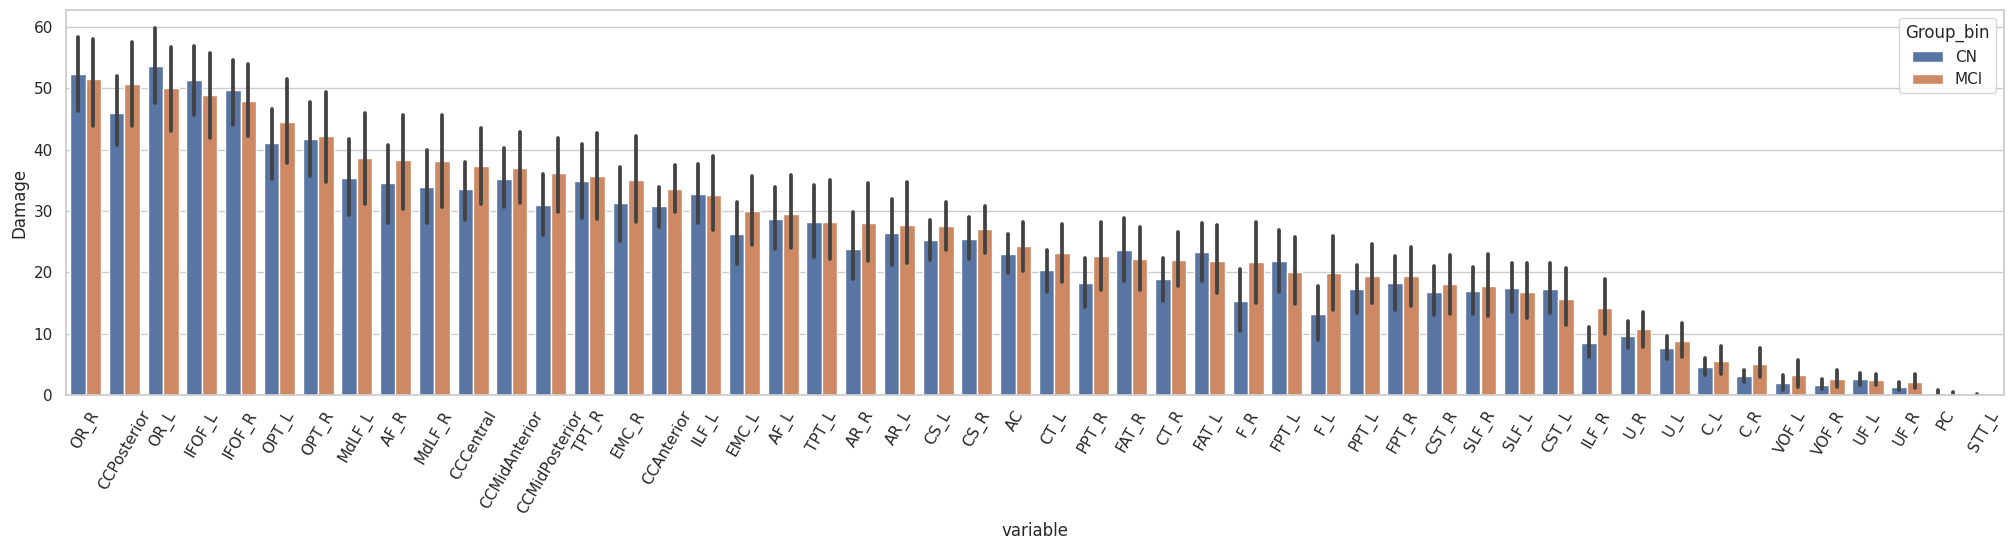

In [4]:
pts_tract_discon_df = pd.merge(help_df, tract_discon, on = "PTID")

# Create long version of the dataframe for plotting with seaborn
val_vars= [f for f in pts_tract_discon_df.columns if f not in ['PTID']]
tract_discon_df_long = pd.melt(pts_tract_discon_df, id_vars = ['PTID', 'Group_bin'], value_vars = val_vars, value_name="Damage")

mci_tract_disc_df_long = tract_discon_df_long[tract_discon_df_long['Group_bin'] == 'MCI']
mean_order = mci_tract_disc_df_long.groupby('variable')['Damage'].mean(numeric_only = True).sort_values(ascending = False)
sns_order = mean_order.index
sns.set(rc={'figure.figsize':(25,5)})
sns.set_theme(style = 'whitegrid')
sns.barplot(data = tract_discon_df_long, x = 'variable', y = "Damage", hue = 'Group_bin', order = sns_order[:-20]) # the last ~ 20 columns are zeros
plt.xticks(rotation = 60);